# **ASI ASSESSED EXERCISE**
Submitted by :- Ankita Sahoo

In [1]:
from google.colab import files
 
uploaded = files.upload()
 
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [2]:
!kaggle competitions download -c santander-customer-transaction-prediction

 96% 120M/125M [00:01<00:00, 95.5MB/s]
100% 125M/125M [00:01<00:00, 89.4MB/s]
  0% 0.00/462k [00:00<?, ?B/s]
100% 462k/462k [00:00<00:00, 148MB/s]
 94% 117M/125M [00:01<00:00, 77.2MB/s] 
100% 125M/125M [00:01<00:00, 67.4MB/s]


In [3]:
from warnings import filterwarnings
filterwarnings(action='ignore', category=RuntimeWarning)

## **PART A: Import Dataset and sampling**

In [4]:
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, log_loss

import scipy as scipy
import scipy.spatial
import time 

import matplotlib 
import matplotlib.font_manager
import matplotlib.pyplot as plt

import warnings
import torch
import torch.nn as nn

warnings.filterwarnings("ignore")
def set_seed(seed: int=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def args_as_tensors(*index):
    """A simple decorator to convert numpy arrays to torch tensors"""
    def decorator(method):
        def wrapper(*args, **kwargs):
            converted_args = [torch.tensor(a).float() 
                              if i in index and type(a) is np.ndarray else a 
                              for i, a in enumerate(args)]
            return method(*converted_args, **kwargs)
        return wrapper  
    return decorator

In [5]:
# defining sigmoid function
def logistic_np(arr):
    return 1 / (1 + np.exp(-arr))

In [6]:
try:
    data_df = pd.read_csv("/content/train.csv.zip")
    display(data_df[:5])
except FileNotFoundError:
    print('File not found!!!')

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [7]:
X_df, y_df = data_df.drop(['ID_code', 'target'], axis=1), data_df[['target']]

In [8]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.5, random_state=42)

In [9]:
print('Dataset size:', len(data_df))
print('Input dimension: {}'.format(data_df.shape[1]-2))
print('Train data:', X_train_df.shape)
print('Test data:', X_test_df.shape)

Dataset size: 200000
Input dimension: 200
Train data: (100000, 200)
Test data: (100000, 200)


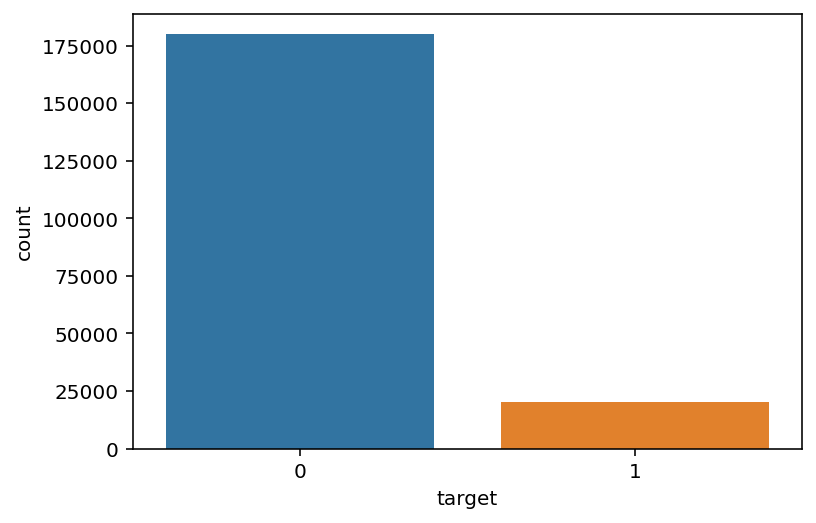

In [10]:
sns.countplot(x='target', data=data_df)
plt.show()

## **PART B: Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis**

As we can see, we have an imbalanced data set. In fact, there are about 8 times more samples labeled 0 than samples labeled as 1. This can cause a problem for the training process because the model won't probably be able to learn well about samples labeled as 1.

Also, we can notice that there are 200 different features. A high dimensionality of the data can cause a problem of data sparsity, i.e. the more we add features, the more samples will be different. It's harder to learn patterns in data

## **1. Bayesian Linear Regression**

**a) Implement Bayesian linear regression**

The next step is to define different functions to be used for Bayesian Linear Regression such as the log-likelihood and the posterior functions as defined in the next equations:

* Log-likelihood: $\log p(\mathbf{y}|\mathbf{w}, \mathbf{X}, \sigma_\mathrm{n}) =  \sum_{i=1}^N  \log\mathcal{N}(y_i|\tilde y_i, \sigma_\mathrm{n})$
    
* Posterior: $p(\mathbf{w}|\mathbf{X}, \mathbf{y}, \sigma_\mathrm{n}) = \mathcal{N}\left(\frac{1}{\sigma^2_\mathrm{n}}\mathbf{\Sigma}\mathbf{X}^\top\mathbf{y}, \mathbf{\Sigma} \right)$ where $\mathbf{\Sigma}^{-1} = \left(\frac{1}{\sigma^2_\mathrm{n}}\mathbf{X}^\top\mathbf{X} + \mathbf{S}^{-1}  \right)$.

In [11]:
def lognormal(x, mu, va):
    return np.log( 1/(np.sqrt(2*np.pi*va)) * np.exp(-0.5 / va * np.subtract(x, mu)**2) )

In [12]:
def compute_posterior(X, y, sigma2priorweights, sigma2noise):
  S = sigma2priorweights * np.eye(X.shape[1])
  Sigma_inverse =  np.linalg.inv(S)  # TO COMPLETE
  posterior_Sigma = np.linalg.inv((1/sigma2noise) * (X.T.dot(X)) + Sigma_inverse) # TO COMPLETE
  posterior_mu =  (1/sigma2noise) * posterior_Sigma.dot((X.T).dot(y))  # TO COMPLETE
    
  return posterior_mu, posterior_Sigma

**b) Describe any pre-processing that you suggest for this data**

Ans) For this data we can do Normalisation which improves the accuracy of the Model. Without Normalisation we get an accuracy of 31% but after applying normalisation we get an accuracy of 59%. Below there is an explanation why Normalisation can be used as a pre-processing step.

Let's show a quick descrition of our data in order to be able to discuss any pre-processing tasks.

In [13]:
X_train_df.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,10.682511,-1.644561,10.717611,6.794643,11.075266,-5.072755,5.404610,16.549642,0.273458,7.570398,0.408728,-3.238209,14.024758,8.538807,7.542690,14.571029,9.328183,-5.717926,15.238331,12.410716,13.299401,17.283613,4.318081,3.019947,10.581589,13.66869,-4.063479,-1.135397,5.533162,5.055119,-7.690428,10.390875,-0.507524,14.770799,11.434605,3.847914,2.180051,5.875915,10.621999,0.663473,...,24.250864,5.633623,5.361163,11.003436,-2.861571,19.334213,2.962148,-4.166351,4.934540,5.636754,-0.004968,-0.830317,19.837104,-0.697174,20.182655,11.637672,-2.805868,11.88636,-1.007320,2.594910,-2.753047,10.081303,0.716312,8.752584,12.774321,-3.984431,8.979121,-10.343996,15.382797,0.743498,3.238730,7.427666,1.930327,3.336448,17.996018,-0.143652,2.317715,8.908212,15.858791,-3.354106
std,3.028838,4.048450,2.636751,2.050977,1.623873,7.858926,0.864711,3.418752,3.327819,1.234759,5.503990,5.971707,0.190087,4.638688,2.246881,0.411870,2.554261,6.713747,7.842195,7.990891,5.875341,8.194951,2.847227,0.527446,3.781389,0.28537,5.923233,1.523092,0.783583,2.612553,7.970681,2.161004,2.591861,4.318418,0.540570,5.168198,3.121526,2.252810,4.281346,4.062668,...,10.916390,0.217617,1.422445,5.251950,5.453121,5.023326,0.369609,7.804109,3.106539,0.369893,4.432982,5.379752,8.668058,5.977722,7.131422,2.881531,7.522807,2.62769,8.585993,2.804534,5.268624,1.370431,8.957852,4.483073,9.318115,4.729081,3.192818,11.560876,3.939776,0.975654,4.551139,3.026107,1.478812,3.995638,3.133970,1.429364,5.458834,0.919052,3.011895,10.430719
min,0.452800,-15.043400,2.117100,-0.040200,5.831600,-32.562600,2.496000,5.349700,-9.865500,3.970500,-19.443900,-26.095000,13.434600,-4.681600,1.169000,13.233900,0.806500,-33.380200,-10.664200,-12.402500,-5.432200,-9.940600,-4.878200,1.244200,-0.678400,12.76020,-24.243100,-5.986900,2.798900,-4.305300,-32.755100,2.140600,-8.943500,2.111100,9.816900,-14.818600,-7.908000,-1.183400,-6.337100,-13.737200,...,-7.452200,4.896600,0.623100,-5.988000,-19.255900,3.816700,1.921700,-35.223300,-5.183800,4.428200,-14.506000,-22.479300,-9.549500,-22.748700,-2.374300,3.241500,-28.292700,5.00250,-28.763900,-7.856100,-19.493600,5.527300,-26.001100,-4.676100,-15.763900,-22.583300,-3.022300,-46.598100,4.412300,-2.455300,-14.093300,-2.691700,-3.814500,-11.783400,8.907400,-5.261000,-14.

Why Normalization can be used as a pre processing step?

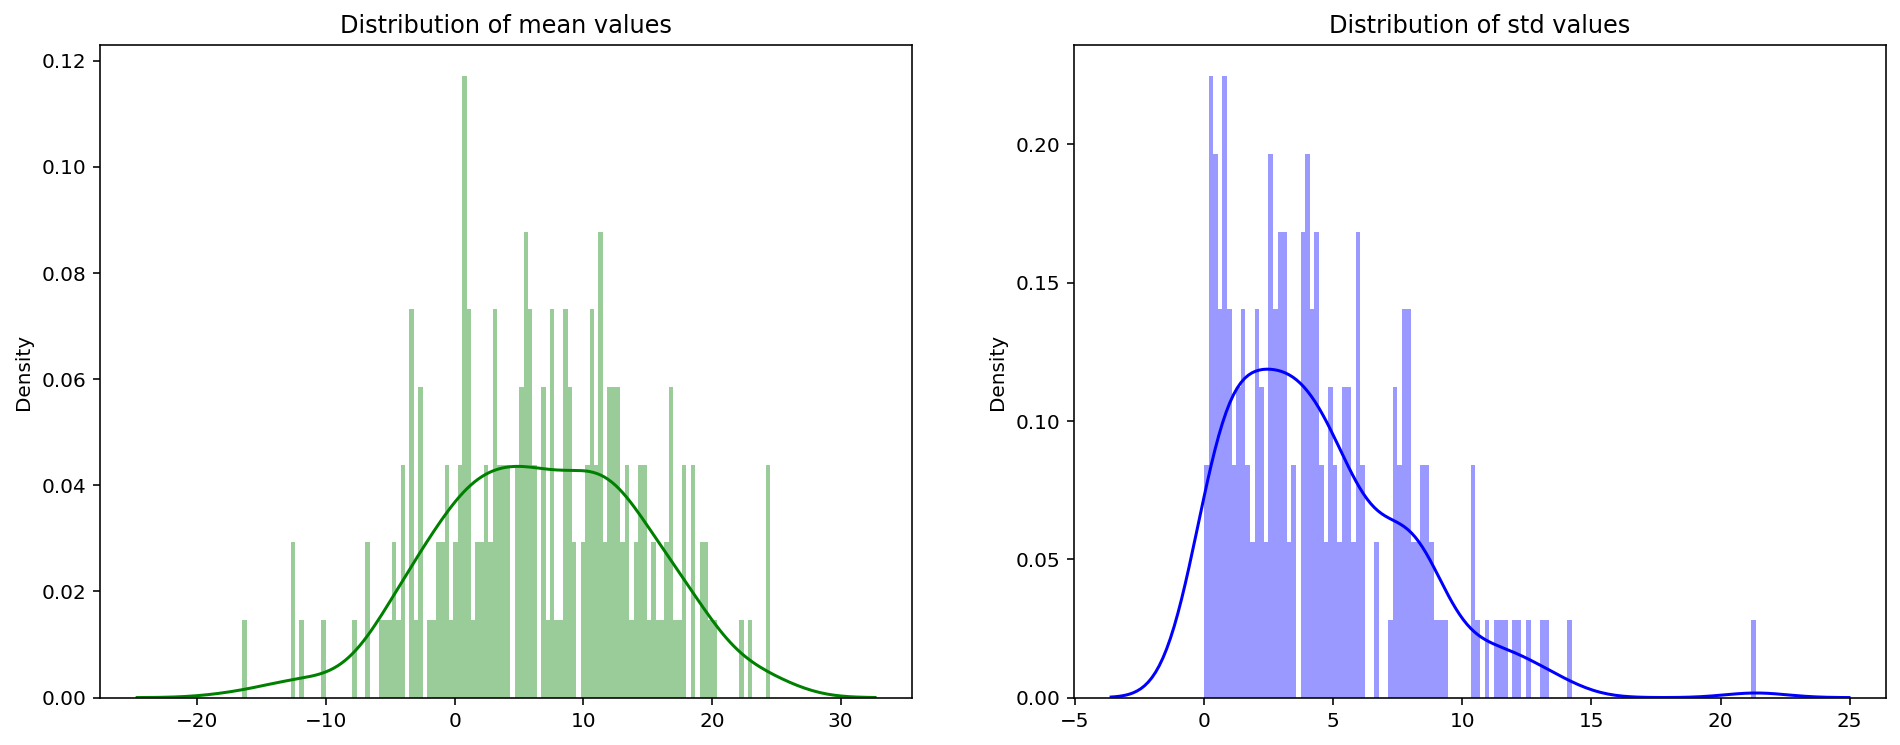

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
sns.distplot(X_train_df.mean(axis=0), color="green", kde=True, bins=120, ax=ax1)
sns.distplot(X_train_df.std(axis=0), color="blue", kde=True, bins=120, ax=ax2)

ax1.set_title('Distribution of mean values')
ax2.set_title('Distribution of std values')

plt.show()

The mean values have a wide distribution range (from  −16  to  24 ) and the std can reach high values (up to  21 ).

Normalizing data by substracting the mean and dividing by the std value of each column. This normalizing step is very important in order to avoid any scaling problem (e.g distances between points won't be dominated by features with high values) and also to speed up the training process (e.g. gradient descent will converge faster).

Note: Both training and testing sets should be normalized with the same mean and std values (of the training set) otherwise we get a biased model.

The next figure shows the new distribution of data values.

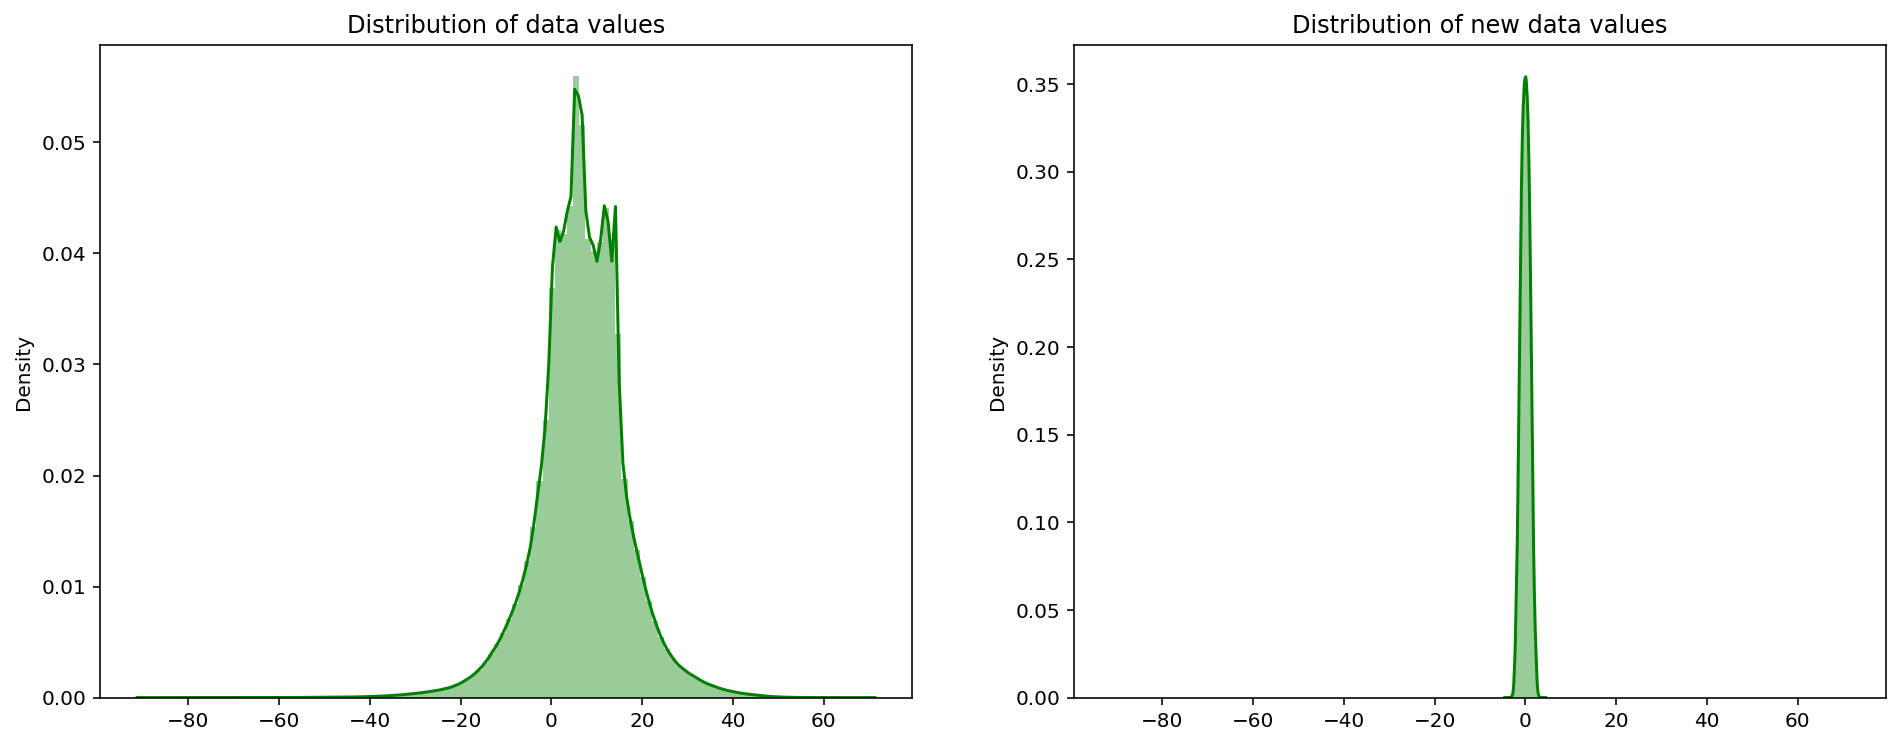

In [15]:
norm_train_df = (X_train_df - X_train_df.mean(axis=0)) / X_train_df.std(axis=0)
norm_test_df = (X_test_df - X_train_df.mean(axis=0)) / X_train_df.std(axis=0)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex='all')
sns.distplot(X_train_df, color="green", kde=True, bins=120, ax=ax1)
sns.distplot(norm_train_df, color="green", kde=True, bins=120, ax=ax2)

ax1.set_title('Distribution of data values')
ax2.set_title('Distribution of new data values')

plt.show()

Note: Same x scale is used so that the difference between the distributions can be spotted.

**Checking the Correlation between different features**

Different features can eventually have high correlations between them that means the corresponding columns give almost the same information, so we can get rid of extra ones.

In [16]:
# correlation matrix
corrmat = np.abs(norm_train_df.corr()).unstack().sort_values(kind="quicksort").reset_index()
corrmat = corrmat[corrmat['level_0'] != corrmat['level_1']]
corrmat.tail(1)

,level_0,level_1,0
39799,var_72,var_26,0.016901


We notice that there is no important correlation between different features. The highest correlation value is  0.0169 between var_26 and var_72.

**c) Treat class labels as continuous and apply regression to the training data. Also, calculate and report the posterior variance of the weights.**

*First let's extract the featues and target, and store them in the appropriate data structures (numpy arrays).*

In [17]:
X, y = norm_train_df.values, y_train_df.values
X_test, y_test = norm_test_df.values, y_test_df.values

print("Features matrix shape:", X.shape)
print("Targets vector shape:", y.shape)

Features matrix shape: (100000, 200)
Targets vector shape: (100000, 1)


In [18]:
sigma2priorweights = 1
sigma2noise = 1
#applying regression
w_posterior_mu, w_posterior_Sigma = compute_posterior(X, y, sigma2priorweights, sigma2noise)

In [19]:
print("Posterior Variance of Weights shape:", w_posterior_Sigma.shape)
print()
print("Posterior Variance of Weights:")
print(w_posterior_Sigma)

Posterior Variance of Weights shape: (200, 200)

Posterior Variance of Weights:
[[ 1.00252844e-05  1.26052739e-08 -4.30591454e-08 ...  1.78704944e-08
   3.63445699e-08 -2.19924933e-10]
 [ 1.26052739e-08  1.00262896e-05 -4.68226339e-08 ...  3.59381655e-08
   1.71524661e-08 -3.13641082e-08]
 [-4.30591454e-08 -4.68226339e-08  1.00266130e-05 ... -1.94215432e-08
   4.18680612e-08 -7.90526860e-09]
 ...
 [ 1.78704944e-08  3.59381655e-08 -1.94215432e-08 ...  1.00229060e-05
   8.08624177e-09 -5.01515246e-08]
 [ 3.63445699e-08  1.71524661e-08  4.18680612e-08 ...  8.08624177e-09
   1.00223508e-05  3.63488182e-08]
 [-2.19924933e-10 -3.13641082e-08 -7.90526860e-09 ... -5.01515246e-08
   3.63488182e-08  1.00177434e-05]]


**D) Suggest a way to discretize predictions and display the confusion matrix on the test data and report accuracy.**

Ans) Inorder to discretize prediction
1. We can opt for applying the sigmoid function to the output to squize the values between 0 and 1 as we are getting a continuous label variable. Then define a threshold (e.g. 0.5). All values above the threshold will be labeled as 1. Other values will be labeled as 0.
2. Simply class positive values as 1 and negative as 0.(Followed this method)

In [20]:
def compute_predictive(Xnew, w_posterior_mu, w_posterior_Sigma, sigma2noise):
    y_posterior_mu = np.dot(Xnew, w_posterior_mu)
    y_posterior_sigma2 = sigma2noise + np.array([(xn.T).dot(w_posterior_Sigma).dot(xn) for xn in Xnew])
    return y_posterior_mu, y_posterior_sigma2

In [21]:
y_posterior_mu, y_posterior_sigma2 = compute_predictive(X_test, w_posterior_mu, w_posterior_Sigma, sigma2noise)

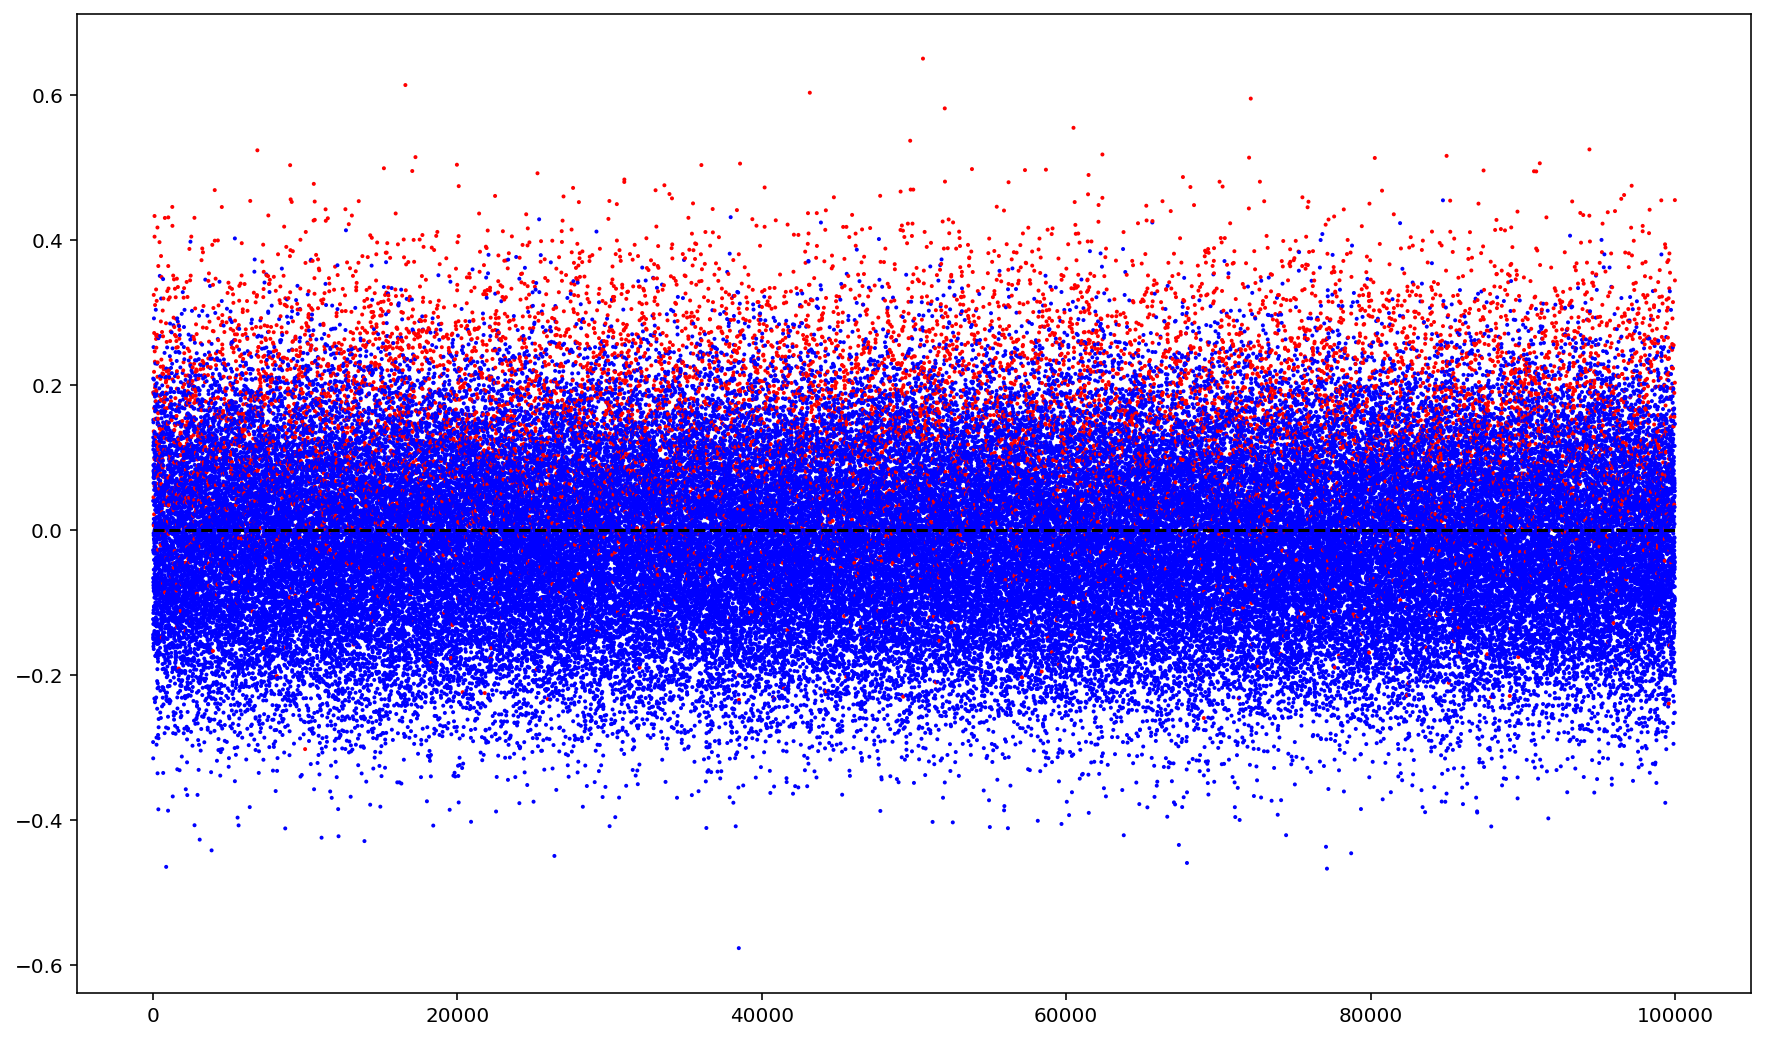

In [22]:
fig, ax = plt.subplots(figsize=[15, 9])
plt.scatter(x=range(X_test.shape[0]), y=(y_posterior_mu[...,0]), c=y_test[...,0], s=1, marker='o', cmap='bwr')
ax.hlines(y=0, xmin=0, xmax=100000, linestyles='dashed')
plt.show()

In [23]:
y_pred = (y_posterior_mu[:,0] > 0).astype(int)
conf_mat = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
loss= log_loss(y_test, y_pred)

print('Accuracy = {:.2f}%'.format(100 * acc))
print('Log-Loss = {:.2f}%'.format(loss))
print()
print(classification_report(y_test, y_pred))

Accuracy = 59.69%
Log-Loss = 13.92%

              precision    recall  f1-score   support

           0       0.98      0.56      0.71     89862
           1       0.19      0.91      0.31     10138

    accuracy                           0.60    100000
   macro avg       0.59      0.74      0.51    100000
weighted avg       0.90      0.60      0.67    100000



Text(33.0, 0.5, 'y_true')

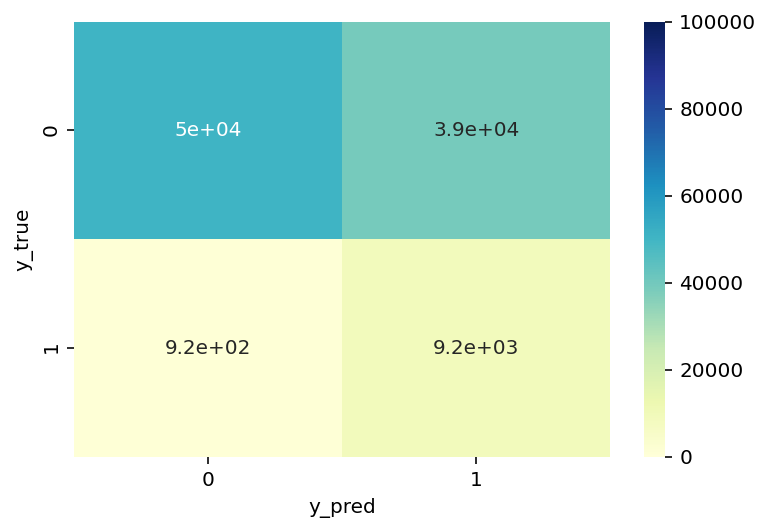

In [24]:
f, ax = plt.subplots(1,1)
sns.heatmap(conf_mat, annot=True, vmin=0, vmax=y_pred.shape[0], cmap="YlGnBu", ax=ax)
ax.set_xlabel('y_pred')
ax.set_ylabel('y_true')

## **2. Logistic Regression**

**A. The goal is to implement a Bayesian logistic regression classifier; assume a Gaussian prior on the parameters. As a first step, implement a Markov chain Monte Carlo inference algorithm to infer parameters.**

In [25]:
jitter = 1e-9

class BernoulliLikelihood():
    def logdensity(self, y, p):
        return y * np.log(p+jitter) + (1-y) * np.log(1-p+jitter)  # division by zero error was fetched, thus adding jitter 1e-9

class NormalPrior():
    def __init__(self, sigma2x):
        self.sigma2x = sigma2x
        
    def logdensity(self, x):
        return -0.5 * x.T @ (self.sigma2x**-1 * np.eye(len(x))) @ x

In [26]:
class MHSampler():
    @property
    def samples(self):
        return self._samples
    @samples.getter    
    def samples(self):
        return np.asarray(self._samples)
    
    def __init__(self, initial_sample, likelihood, prior):
        self.likelihood = likelihood
        self.prior = prior
        self._samples = [initial_sample]
        
        
    def unnormalized_logposterior(self, w, X, y):
        log_likelihood = self.likelihood.logdensity(y, logistic_np(X @ w)).sum() ## *** TO COMPLETE *** ##
        log_prior = self.prior.logdensity(w) ## *** TO COMPLETE *** ##
        return log_likelihood + log_prior

    def step(self, X, y, step_proposal):
        w_prev = self._samples[-1]
        w_proposal = np.random.randn(*w_prev.shape) * step_proposal + w_prev ## *** TO COMPLETE *** ##
        # generate w_s from p(w_s|w_s-1)
        
        
        log_gw_prev = self.unnormalized_logposterior(w_prev,X,y) ## *** TO COMPLETE *** ##
        log_gw_proposal = self.unnormalized_logposterior(w_proposal,X,y) ## *** TO COMPLETE *** ##

        log_acceptance_ratio = log_gw_proposal-log_gw_prev ## *** TO COMPLETE *** ##
        acceptance_ratio = np.exp(log_acceptance_ratio) ## *** TO COMPLETE *** ##

        if acceptance_ratio >= 1: ## *** TO COMPLETE *** ##
            self._samples.append(w_proposal)
        else:
            u = np.random.uniform(0.0, 1.0, size=1) ## *** TO COMPLETE *** ##
            if u <= acceptance_ratio: ## *** TO COMPLETE *** ##
                self._samples.append(w_proposal)
            else:
                self._samples.append(w_prev)
        
        return min(acceptance_ratio, 1)

def predict(x_new, w_samples):
    return np.mean(logistic_np(x_new @ w_samples), 0) ## *** TO COMPLETE *** ##

In [27]:
from sklearn.utils import resample

data_df = pd.read_csv("/content/train.csv.zip")
train_df, test_df = train_test_split(data_df, test_size=0.5, random_state=42)


# Separate majority and minority classes
df_majority = train_df[train_df.target==0]
df_minority = train_df[train_df.target==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=10000,     # to match minority class
                                 random_state=42) # reproducible results
 
# Combine minority class with downsampled majority class
train_df = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
print(train_df.target.value_counts())


X_df, y_df = train_df.drop(['ID_code', 'target'], axis=1), train_df[['target']]
X_test_df, y_test_df = test_df.drop(['ID_code', 'target'], axis=1), test_df[['target']]
X_u, y_u = X_df.values, y_df.values
X_test_u, y_test_u = X_test_df.values, y_test_df.values


X_u = (X_u - np.mean(X_u, axis=0)) / np.std(X_u, axis=0)
X_test_u = (X_test_u - np.mean(X_u, axis=0)) / np.std(X_u, axis=0)

0    10000
1     9960
Name: target, dtype: int64


In [28]:
set_seed()

likelihood = BernoulliLikelihood() ## *** TO COMPLETE *** ##
prior = NormalPrior(sigma2x=1) ## *** TO COMPLETE *** ##

starting_point = np.random.randn(200, 1) ## *** TO COMPLETE *** ##
sampler = MHSampler(initial_sample=starting_point, likelihood=likelihood, prior=prior) ## *** TO COMPLETE *** ##

In [29]:
for i in range(1500):
  sampler.step(X_u, y_u, step_proposal=.01) ## *** TO COMPLETE *** ##
samples_0 = sampler.samples

In [30]:
set_seed()

likelihood = BernoulliLikelihood() ## *** TO COMPLETE *** ##
prior = NormalPrior(sigma2x=1) ## *** TO COMPLETE *** ##

starting_point = np.random.randn(200, 1) ## *** TO COMPLETE *** ##
sampler = MHSampler(initial_sample=starting_point, likelihood=likelihood, prior=prior) ## *** TO COMPLETE *** ##

In [31]:
for i in range(1500):
  sampler.step(X_u, y_u, step_proposal=.5) ## *** TO COMPLETE *** ##
samples_1 = sampler.samples

Changing the step size has also a noticeable impact on the result. In fact with a small step size ( 0.01 ), we were unable to explore the features well, and the algorithm was limited to a small part (check the plot limits). While using a larger step size ( 0.5 ) was useful to explore more space. So we can get a better approximation of the posterior distribution using this value.

In [32]:
#Prediction
y_pred_u = np.rint(predict(X_test_u, sampler.samples))

In [33]:
#Confusion Matrix
conf_mat = confusion_matrix(y_test_u, y_pred_u)
acc = accuracy_score(y_test_u, y_pred_u)
loss = log_loss(y_test_u, y_pred_u)

print('Accuracy = {:.2f}%'.format(100 * acc))
print('Log-Loss = {:.2f}%'.format(loss))
print()
print(classification_report(y_test_u, y_pred_u))

Accuracy = 89.80%
Log-Loss = 3.52%

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     89862
           1       0.24      0.00      0.01     10138

    accuracy                           0.90    100000
   macro avg       0.57      0.50      0.48    100000
weighted avg       0.83      0.90      0.85    100000



Text(33.0, 0.5, 'y_true')

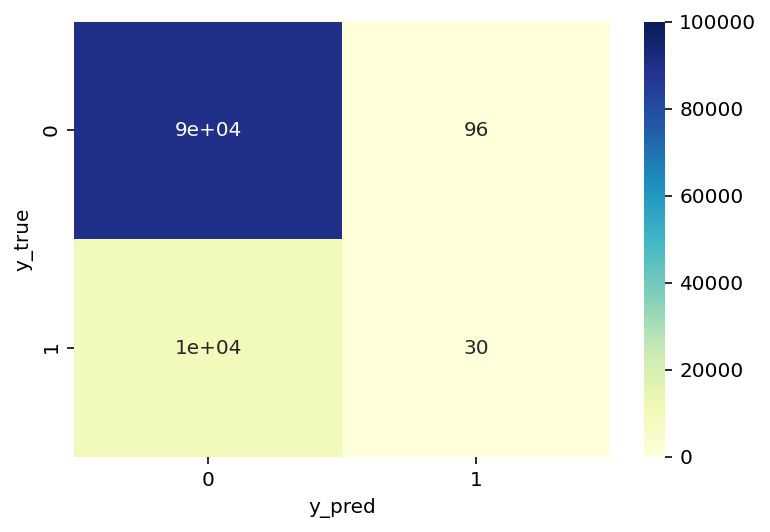

In [34]:
f, ax = plt.subplots(1,1)
sns.heatmap(conf_mat, annot=True, vmin=0, vmax=y_pred_u.shape[0], cmap="YlGnBu", ax=ax)
ax.set_xlabel('y_pred')
ax.set_ylabel('y_true')

**D) Comment on the tuning of the Metropolis-Hastings algorithm, and how to
guarantee that samples are representative of samples of the posterior over model parameters.**

Ans) To tune the Metropolis-Hastings algorithm, the training data set is downsampled in order to get nearly the same number of samlples for each class.In this case Class 0 is downsampled. This seemed to give better results.

Without this step, the model was always predecting class 0, which gave 90% of accuracy but a low f1 score (because 90% of testing data belongs to class 0).

**B) Implement the variational approximation we studied in the course to obtain an approximation to the posterior over model parameters**

In [35]:
jitter = 1e-10

class Distribution(nn.Module):  
    pass
        
class Bernoulli(Distribution):
    @args_as_tensors(1, 2)
    def logdensity(self, y, p):
        return y * torch.log(p + jitter) + (1-y) * torch.log(1-p+jitter) ## *** TO COMPLETE *** ##

In [36]:
class NormalDiagonal(Distribution):
    @property
    def var(self):
        return self.logvar.exp()
    
    def extra_repr(self):
        return 'train=%s' % self.train
    
    def __init__(self, d, train=True):
        super(NormalDiagonal, self).__init__()
        self.train = train
        self.d = d
        self.mean = nn.Parameter(torch.zeros(d), requires_grad=train)
        self.logvar = nn.Parameter(torch.zeros(d), requires_grad=train)
    
    def sample(self, n=1):
        eps = torch.randn(n, self.d, requires_grad=False) ## *** TO COMPLETE *** ##
        samples = self.mean + torch.sqrt(self.var) * eps ## *** TO COMPLETE *** ##    # shape: [n x self.d]
        return samples

In [37]:
from functools import total_ordering

_KL_REGISTRY = {}  # Source of truth mapping a few general (type, type) pairs to functions.
_KL_MEMOIZE = {}  # Memoized version mapping many specific (type, type) pairs to functions.

@total_ordering
class _Match(object):
    __slots__ = ['types']

    def __init__(self, *types):
        self.types = types

    def __eq__(self, other):
        return self.types == other.types

    def __le__(self, other):
        for x, y in zip(self.types, other.types):
            if not issubclass(x, y):
                return False
            if x is not y:
                break
        return True

def _dispatch_kl(type_q, type_p):
    matches = [(super_q, super_p) for super_q, super_p in _KL_REGISTRY
               if issubclass(type_q, super_q) and issubclass(type_p, super_p)]
    if not matches:
        return NotImplemented
    left_q, left_p = min(_Match(*m) for m in matches).types
    right_p, right_q = min(_Match(*reversed(m)) for m in matches).types
    left_fun = _KL_REGISTRY[left_q, left_p]
    right_fun = _KL_REGISTRY[right_q, right_p]
    if left_fun is not right_fun:
        logger.warning('Ambiguous kl_divergence({}, {}). Please register_kl({}, {})'.format(
            type_q.__name__, type_p.__name__, left_q.__name__, right_p.__name__))
    return left_fun


def register_kl(type_q, type_p):
    """
    Decorator to register a pairwise function with kl_divergence.
    Usage:

        @register_kl(Normal, Normal)
        def kl_normal_normal(q, p):
            # insert implementation here
    """
    if not isinstance(type_q, type) and issubclass(type_q, BaseDistribution):
        raise TypeError('Expected type_q to be a Distribution subclass but got {}'.format(type_q))
    if not isinstance(type_p, type) and issubclass(type_p, BaseDistribution):
        raise TypeError('Expected type_p to be a Distribution subclass but got {}'.format(type_p))
    
    def decorator(fun):
        _KL_REGISTRY[type_q, type_p] = fun
        _KL_MEMOIZE.clear()  # reset since lookup order may have changed
        print('KL divergence between \'%s\' and \'%s\' registered.' % (type_q.__name__, type_p.__name__))
        return fun
    return decorator


def kl_divergence(q, p):
    r"""Compute Kullback-Leibler divergence KL(p|q) between two distributions."""
    try:
        fun = _KL_MEMOIZE[type(q), type(p)]
    except KeyError:
        fun = _dispatch_kl(type(q), type(p))
        _KL_MEMOIZE[type(q), type(p)] = fun
    if fun is NotImplemented:
        raise NotImplementedError('KL divergence for pair %s - %s not registered' % (type(q).__name__,
                                                                                     type(p).__name__))
    return fun(q, p)

In [38]:
@register_kl(NormalDiagonal, NormalDiagonal)
def _normaldiagonal_normaldiagonal(q, p):
    kl = 0.5 * torch.sum(p.logvar - q.logvar + (q.var + (q.mean - p.mean)**2) / p.var - 1) ## *** TO COMPLETE *** ##
    return kl

KL divergence between 'NormalDiagonal' and 'NormalDiagonal' registered.


In [39]:
def logistic(z):
    return 1 / (1 + torch.exp(-z)) ## *** TO COMPLETE *** ##

In [40]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        
        self.prior_w = NormalDiagonal(input_dim, train=True) ## *** TO COMPLETE *** ##
        self.posterior_w = NormalDiagonal(input_dim, train=True) ## *** TO COMPLETE *** ##
        
    @args_as_tensors(1)
    def predict_y(self, X, mc_samples=1):
        w_samples = self.posterior_w.sample(n=mc_samples).transpose(0,1) ## *** TO COMPLETE *** ##
        y_samples = logistic(X @ w_samples) ## *** TO COMPLETE *** ##
        return y_samples

In [41]:
class VariationalObjective(nn.Module):    
    def __init__(self, model, likelihood, N, mc_samples=1):
        super(VariationalObjective, self).__init__()
        self.N = N
        self.model = model
        self.likelihood = likelihood
        self.mc_samples = mc_samples
        
    def expected_loglikelihood(self, Xbatch, ybatch):
        ypred = model.predict_y(Xbatch, self.mc_samples) ## *** TO COMPLETE *** ##
        logliks = self.likelihood.logdensity(ybatch, ypred) ## *** TO COMPLETE *** ##
        return self.N * logliks.sum() / (self.mc_samples * len(Xbatch)) ## *** TO COMPLETE *** ##
    
    def kl(self):
        return kl_divergence(self.model.posterior_w, self.model.prior_w) ## *** TO COMPLETE *** ##
    
    def compute_objective(self, Xbatch, ybatch):
        return - self.expected_loglikelihood(Xbatch, ybatch) + self.kl() ## *** TO COMPLETE *** ##

C. Based on samples from the posterior over model parameters, write a function that computes the predictive distribution, and write the necessary functions to evaluate classification metrics such as the log-likelihood on test data and error rate.

In [42]:
likelihood = Bernoulli() ## *** TO COMPLETE *** ##
model = LogisticRegression(X_u.shape[1]) ## *** TO COMPLETE *** ##

In [43]:
nelbo = VariationalObjective(model, likelihood, N=len(X_u), mc_samples=1000) ## *** TO COMPLETE *** ##
print(nelbo)

VariationalObjective(
  (model): LogisticRegression(
    (prior_w): NormalDiagonal(train=True)
    (posterior_w): NormalDiagonal(train=True)
  )
  (likelihood): Bernoulli()
)


In [44]:
set_seed()

objective = nelbo.compute_objective(X_u,y_u) ## *** TO COMPLETE *** ##
print(objective)

tensor(109342.8203, grad_fn=<AddBackward0>)


In [45]:
set_seed()
mc_samples = nelbo.mc_samples
y_pred = 1 / mc_samples * torch.sum(model.predict_y(X_test_u, mc_samples), 1)

In [46]:
y_pred.shape

torch.Size([100000])

In [47]:
y_pred = np.rint(y_pred.detach().numpy())

conf_mat = confusion_matrix(y_test_u, y_pred)
acc = accuracy_score(y_test_u, y_pred)
loss = log_loss(y_test_u, y_pred)

print('Accuracy = {:.2f}%'.format(100 * acc))
print()
print(classification_report(y_test_u, y_pred))

Accuracy = 25.27%

              precision    recall  f1-score   support

           0       0.90      0.19      0.31     89862
           1       0.10      0.80      0.18     10138

    accuracy                           0.25    100000
   macro avg       0.50      0.50      0.25    100000
weighted avg       0.82      0.25      0.30    100000



The Model is not optimised thus the accuracy is low.

**E) Comment on the tuning of the variational inference algorithm, and discuss the behavior of the optimization with respect to the choice of the optimizer/step-size**

Ans) The variational inference algorithm can be tuned by using SGD or an ADAM optimiser with different learning rate values. After trying many combinations, learning rates of  10−2  for Adam Optimizer and  10−5  for SGD seem to give the best optimization values.(Below is the experimentation code)
After using a optimizer the accuracy was improved. Withouth the optimizer variational approximation provided an accuracy of 25.27% which was improved to 89.96% with an optimizer.


In [48]:
class Summary:
    @property
    def data(self):
        data = pd.DataFrame(self._data, columns=['step', self.name, 'time'])
        data.time = data.time - data.time.iloc[0]
        return data
    
    def __init__(self, name):
        """A simple class to store some values during optimization"""
        self.name = str(name)
        self._data = []
    
    def append(self, step, value):
        self._data.append([step, float(value.detach().numpy()), time.time()])

In [49]:
class Dataset():
    def __init__(self, X, y, minibatch_size):
        self.X = X
        self.y = y 
        self.minibatch_size = min(minibatch_size, len(self.X))
        self._i = 0  
    def next_batch(self):  
        if len(self.X) <= self._i + self.minibatch_size:
            shuffle = np.random.permutation(len(self.X))
            self.X = self.X[shuffle]
            self.y = self.y[shuffle]
            Xbatch = self.X[self._i:]
            ybatch = self.y[self._i:]
            self._i = 0
            return Xbatch, ybatch

        Xbatch = self.X[self._i:self._i + self.minibatch_size]
        ybatch = self.y[self._i:self._i + self.minibatch_size]
        self._i += self.minibatch_size
        return Xbatch, ybatch

In [50]:
Dataset = Dataset(X_u, y_u, minibatch_size=1000)

In [51]:
#ADAM optimizer 
likelihood = Bernoulli() ## *** TO COMPLETE *** ##
model = LogisticRegression(X_u.shape[1]) ## *** TO COMPLETE *** ##
nelbo = VariationalObjective(model, likelihood, len(X_u), mc_samples=1000) ## *** TO COMPLETE *** ##

nelbo_summary = Summary('nelbo')
nll_summary = Summary('expected_loglik')
kl_summary = Summary('kl')

#optim = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1) ## *** TO COMPLETE *** ##
optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-2)
num_iterations = 5000

for step in range(num_iterations):
    optim.zero_grad()
    Xbatch, ybatch = Dataset.next_batch() ## *** TO COMPLETE *** ##
    loss =  nelbo.compute_objective(Xbatch, ybatch) ## *** TO COMPLETE *** ##
    
    nelbo_summary.append(step, loss)
    nll_summary.append(step, loss - nelbo.kl())
    kl_summary.append(step, nelbo.kl())
    
    loss.backward()
    optim.step()
    ## *** TO COMPLETE *** ##
    ## *** TO COMPLETE *** ##

In [52]:
#prediction
set_seed()
mc_samples = nelbo.mc_samples
y_pred = 1 / mc_samples * torch.sum(model.predict_y(X_test_u, mc_samples), 1)
y_pred = np.rint(y_pred.detach().numpy())

conf_mat = confusion_matrix(y_test_u, y_pred)
acc = accuracy_score(y_test_u, y_pred)
loss = log_loss(y_test_u, y_pred)

print('Accuracy = {:.2f}%'.format(100 * acc))
print()
print(classification_report(y_test_u, y_pred))

Accuracy = 89.86%

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     89862
           1       0.00      0.00      0.00     10138

    accuracy                           0.90    100000
   macro avg       0.45      0.50      0.47    100000
weighted avg       0.81      0.90      0.85    100000



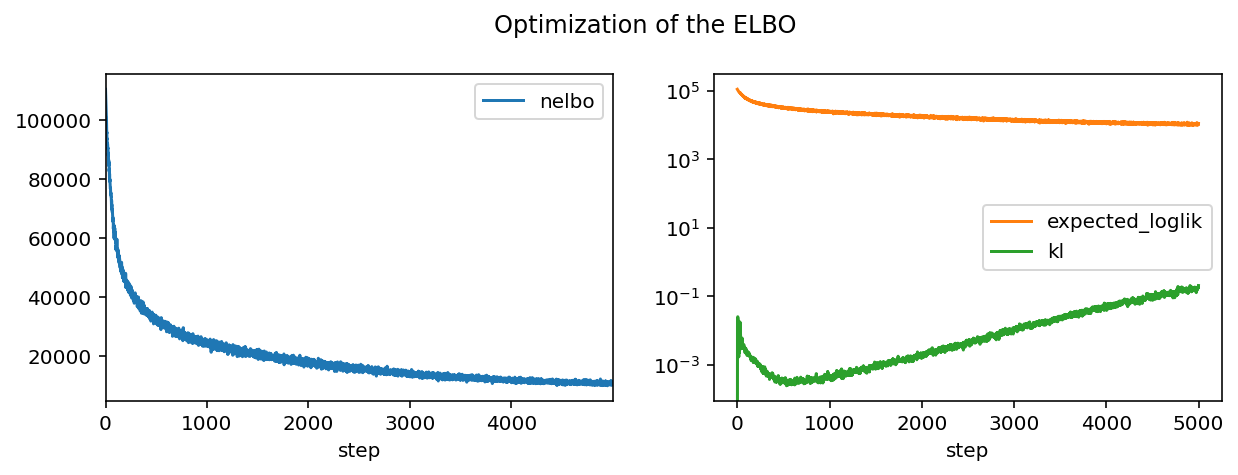

In [53]:
fig, axs = plt.subplots(1, 2, figsize=[10, 3])

nelbo_summary.data.plot(x='step', y='nelbo', ax=axs[0]);
nll_summary.data.plot(x='step', y='expected_loglik', ax=axs[1], c='C1');
kl_summary.data.plot(x='step', y='kl', ax=axs[1], c='C2');
axs[1].semilogy();
fig.suptitle('Optimization of the ELBO', y=1.02)
axs[0].margins(0, 0.05)

In [54]:
#SGD optimizer
likelihood = Bernoulli() ## *** TO COMPLETE *** ##
model = LogisticRegression(X_u.shape[1]) ## *** TO COMPLETE *** ##
nelbo = VariationalObjective(model, likelihood, len(X_u), mc_samples=1000) ## *** TO COMPLETE *** ##

nelbo_summary = Summary('nelbo')
nll_summary = Summary('expected_loglik')
kl_summary = Summary('kl')

#optim = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1) ## *** TO COMPLETE *** ##
optim = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)
num_iterations = 5000

for step in range(num_iterations):
    optim.zero_grad()
    Xbatch, ybatch = Dataset.next_batch() ## *** TO COMPLETE *** ##
    loss =  nelbo.compute_objective(Xbatch, ybatch) ## *** TO COMPLETE *** ##
    
    nelbo_summary.append(step, loss)
    nll_summary.append(step, loss - nelbo.kl())
    kl_summary.append(step, nelbo.kl())
    
    loss.backward()
    optim.step()
    ## *** TO COMPLETE *** ##
    ## *** TO COMPLETE *** ##

In [55]:
#prediction
set_seed()
mc_samples = nelbo.mc_samples
y_pred = 1 / mc_samples * torch.sum(model.predict_y(X_test_u, mc_samples), 1)
y_pred = np.rint(y_pred.detach().numpy())

conf_mat = confusion_matrix(y_test_u, y_pred)
acc = accuracy_score(y_test_u, y_pred)
loss = log_loss(y_test_u, y_pred)

print('Accuracy = {:.2f}%'.format(100 * acc))
print()
print(classification_report(y_test_u, y_pred))

Accuracy = 89.86%

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     89862
           1       0.00      0.00      0.00     10138

    accuracy                           0.90    100000
   macro avg       0.45      0.50      0.47    100000
weighted avg       0.81      0.90      0.85    100000



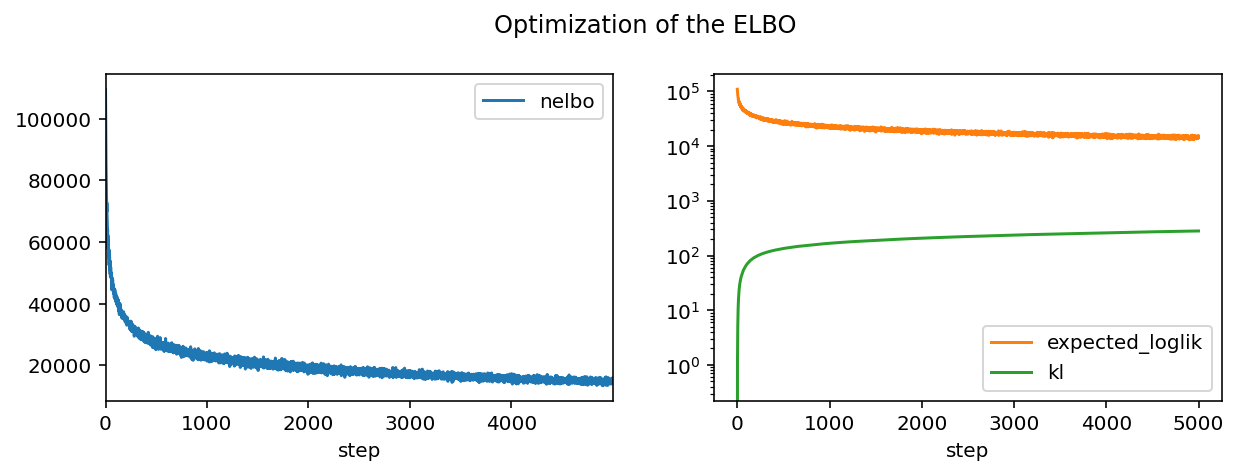

In [56]:
fig, axs = plt.subplots(1, 2, figsize=[10, 3])

nelbo_summary.data.plot(x='step', y='nelbo', ax=axs[0]);
nll_summary.data.plot(x='step', y='expected_loglik', ax=axs[1], c='C1');
kl_summary.data.plot(x='step', y='kl', ax=axs[1], c='C2');
axs[1].semilogy();
fig.suptitle('Optimization of the ELBO', y=1.02)
axs[0].margins(0, 0.05)

**F) Report the error metrics implemented in point 2.B. above and the confusion matrix on the test data. Discuss logistic regression performance with respect to the performance of Bayesian linear regression.**

The confusion matrix and the classification matrix for the respective scenarios are plotted above. 
Logistic Regression produce a probability of a sample belonging to a class, instead Bayesian Linear Regression gives a value that it's not between 0 and 1. An error in prediction and as per the error rate matrix we see Logistic Regression are more accurate and also have a better weighted f1 score.
With Bayesian Linear Regression we obtained a accuracy of about 59% only where as with Logistic Regression we got an accuracy of about 90% approximately.

**G) Compare the uncertainties on predictions obtained by the Metropolis-Hastings algorithm and variational inference. First, compare the log-likelihood on test data as a global metric to assess which inference method yields better uncertainty quantification.
Second, pick a few test points for which the mean of the predictive distribution is (a) around 0.5 (b) giving a correct prediction (c) giving a wrong prediction, and visualize/discuss what the predictive distribution looks like. Discuss the difference between the Metropolis-Hastings algorithm and variational inference**

Ans) 
1. MCMC sampling is best for smaller dataset but needs a heavy computational power where as Variational Inference is good for large datasets and is also computational faster.
2. MCMC is more exact than VI. MCMC by constructing a Markov chain will estimate the appropiate target distribution where the VI will estimate the approximate one not the exact one.
Below is a predictive distribution graph, which shows for VI when we have take more samples we get more precise approximation of the distribution with a small variance value.
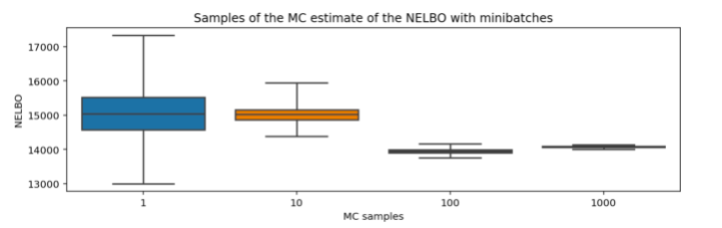

In [57]:
# set_seed()

# nelbo_samples = {}
# num_of_nelbo_samples = 1000

# with torch.no_grad():
#     Xbatch,ybatch=Dataset.next_batch()
#     nelbo.mc_samples = 1
#     nelbo_samples['1'] = [nelbo.compute_objective(Xbatch,ybatch) for _ in range(num_of_nelbo_samples)] ## *** TO COMPLETE *** ##
    
#     Xbatch,ybatch=Dataset.next_batch()
#     nelbo.mc_samples = 10
#     nelbo_samples['10'] = [nelbo.compute_objective(Xbatch,ybatch) for _ in range(num_of_nelbo_samples)] ## *** TO COMPLETE *** ##
    
#     Xbatch,ybatch=Dataset.next_batch()
#     nelbo.mc_samples = 100
#     nelbo_samples['100'] = [nelbo.compute_objective(Xbatch,ybatch) for _ in range(num_of_nelbo_samples)] ## *** TO COMPLETE *** ##
    
#     Xbatch,ybatch=Dataset.next_batch()
#     nelbo.mc_samples = 1000
#     nelbo_samples['1000'] = [nelbo.compute_objective(Xbatch,ybatch) for _ in range(num_of_nelbo_samples)] ## *** TO COMPLETE *** ##

# fig, ax = plt.subplots(figsize=[11, 3])
# sns.boxplot(data=pd.DataFrame(nelbo_samples), ax=ax,  whis=np.inf )
# ax.set_title('Samples of the MC estimate of the NELBO with minibatches')
# ax.set_xlabel('MC samples')
# ax.set_ylabel('NELBO')
# ax.margins(0,0.05)
# plt.show()